# Test multi-modal 2D
---
Description:

- Optimization (max)
- Multimodal (yes)
---

The equations are given by the Multivariate Normal Distribution, with **four** modes:

$f\left(\mathbf{x}\right) = \sum_{i=1}^{4}{\cal N}(\mu_i, \Sigma_i)$,

with mean vectors: $\mu_1 = [-0.0, -1.0]$, $\mu_2 = [-4.0, -6.0]$, $\mu_3 = [-5.0, +1.0]$, $\mu_4 = [5.0, -10.0]$,

and covariances: $\Sigma_1 = \begin{bmatrix} 1.0 & 0.1 \\ 0.1 & 1.0\end{bmatrix}$, 
$\Sigma_2 = \begin{bmatrix} 1.0 & 0.1 \\ 0.1 & 1.0\end{bmatrix}$, $\Sigma_3 = \begin{bmatrix} 1.2 & 0.3 \\ 0.3 & 1.2\end{bmatrix}$,
$\Sigma_4 = \begin{bmatrix} 1.2 & 0.3 \\ 0.3 & 1.2\end{bmatrix}$.

## First we import python libraries and set up the directory

In [323]:
import os, sys
import numpy as np
from numba import njit
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from collections import defaultdict

# Enable LaTex in plotting.
plt.rcParams["text.usetex"] = True

PROJECT_DIR = os.path.abspath("..")
sys.path.append(PROJECT_DIR)

## Here we import all our custom PSO code

In [324]:
# Import main classes.
from pygenalgo.genome.gene import Gene
from pygenalgo.genome.chromosome import Chromosome
from pygenalgo.utils.utilities import cost_function
from pygenalgo.engines.standard_ga import StandardGA

# Import Selection Operator(s).
from pygenalgo.operators.selection.random_selector import RandomSelector
from pygenalgo.operators.selection.linear_rank_selector import LinearRankSelector
from pygenalgo.operators.selection.neighborhood_selector import NeighborhoodSelector

# Import Crossover Operator(s).
from pygenalgo.operators.crossover.uniform_crossover import UniformCrossover

# Import Mutation Operator(s).
from pygenalgo.operators.mutation.random_mutator import RandomMutator
from pygenalgo.operators.mutation.meta_mutator import MetaMutator

# Quasi-Monte-Carlo methods.
from scipy.stats import qmc

In [325]:
def count_particles_per_mode(x_pos: np.ndarray, modes: list,
                             radius: int = 1) -> dict:
    cppm = defaultdict(int)

    for px, py in x_pos:
        for vals in modes:
            cx, cy = vals
            if (px - cx)**2 + (py - cy)**2 <= radius**2:            
                cppm[tuple(vals)] += 1
                break
            # _end_if_
    # _end_for_
    return cppm
# _end_def_

## Setup the 2D functions

In [326]:
# Setup the 2D Gaussian functions.
# NOTE: Because of their covariance setup, the first two (mvn_1 and mvn_2)
# will have higher modes then the other two. So the maximum will be in one
# of these two modes.

# Each one with different mean and covariance matrix.
mvn_1 = multivariate_normal([-0.0, -1.0], [[1.0, 0.1], [0.1, 1.0]])

mvn_2 = multivariate_normal([-4.0, -6.0], [[1.0, 0.1], [0.1, 1.0]])

mvn_3 = multivariate_normal([-10.0, 5.0], [[1.2, 0.3], [0.3, 1.2]])

mvn_4 = multivariate_normal([5.0, -10.0], [[1.2, 0.3], [0.3, 1.2]])

# Define the negative log of the pdfs.
def negative_log_pdfx(x: np.ndarray) -> float:
    return -np.log(mvn_1.pdf(x) + mvn_2.pdf(x) + mvn_3.pdf(x) + mvn_4.pdf(x))
# _end_def_

## Define the multi-modal function

In [327]:
@cost_function(minimize=True)
def fun_test2D(individual: Chromosome) -> float:
    # Extract the x,y values.
    x, y = individual.values()
    
    # Compute the final value.
    f_value = negative_log_pdfx([x, y])
    
    # Return the solution.
    return f_value.item()
# _end_def_

## Here we set the GA parameters

Then we set the GA parameters, such as the genes, the number of chromosomes, etc.

In [328]:
# Random number generator.
rng = np.random.default_rng()

# Random function that enforce the boundaries in x/y.
boundary_xy = lambda: rng.uniform(-15.0, 15.0)

# Define the number of chromosomes.
N, D = 500, 2

# Define the sampling method.
sample_method = "QMC"

if sample_method == "RANDOM":
    # Draw random samples for the initial points.
    xy_init = rng.uniform(-15.0, 15.0, size=(N, D))
else:
    # Draw samples using Latin Hyper Cube approach.
    sampler = qmc.LatinHypercube(D, optimization="random-cd", rng=rng)

    # Sample initial population.
    xy_init = sampler.random(N)
    
    # Scale the populaiton.
    xy_init = qmc.scale(xy_init, [-15.0, -15.0], [15.0, 15.0])
# _end_if_


# Initial population.
population = [Chromosome([Gene(xy_init[i, 0], boundary_xy),
                          Gene(xy_init[i, 1], boundary_xy)], np.nan, True)
              for i in range(N)]

# Create the StandardGA object that will carry on the optimization.
test_GA = StandardGA(initial_pop=population,
                     fit_func=fun_test2D,
                     select_op=NeighborhoodSelector(),
                     mutate_op=RandomMutator(),
                     crossx_op=UniformCrossover())

## Optimization process

In [329]:
test_GA(epochs=500, elitism=True, shuffle=True, verbose=False)

Initial Avg. Fitness = -34.6400
Final   Avg. Fitness = -16.9926
Elapsed time: 153.546 seconds.


In [330]:
# Extract the data values as 'x' and 'y', for parsimony.
x_opt, y_opt = test_GA.best_chromosome().values()

# Compute the final objective functions.
f_opt = negative_log_pdfx([x_opt, y_opt])

# Print the resutls.
print(f"x={x_opt:.5f}, y={y_opt:.5f}", end='\n\n')
print(f"f_opt(x, y) = {f_opt:.5f}")

x=-4.04459, y=-5.98660

f_opt(x, y) = 1.83401


In [331]:
best_n = []

for p in test_GA.best_n(n=N):
    best_n.append(p.values())

best_n = np.array(best_n)

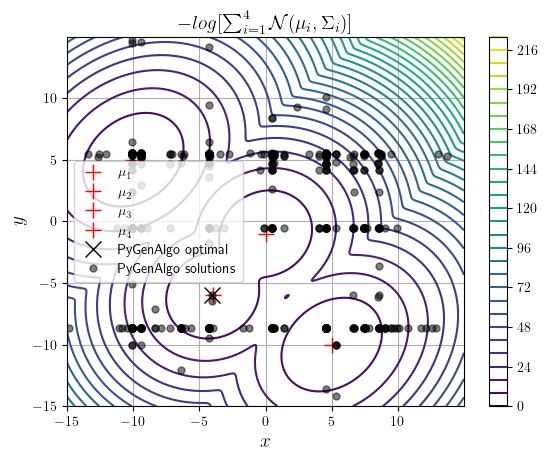

In [332]:
# Prepare the plot of the real density.
x, y = np.mgrid[-15:15:0.01, -15:15:0.01]

# Stack the position of the grid together.
pos = np.dstack((x, y))

# First plot the contour of the "true" function.
plt.contour(x, y, negative_log_pdfx(pos), levels=30)

# Add the three modes.
plt.plot(+0.0, -1.0, "r+", label="$\mu_1$", markersize=12)
plt.plot(-4.0, -6.0, "r+", label="$\mu_2$", markersize=12)
plt.plot(-10.0, 5.0, "r+", label="$\mu_3$", markersize=12)
plt.plot(5.0, -10.0, "r+", label="$\mu_4$", markersize=12)

# Plot the optimal GA.
plt.plot(x_opt, y_opt, "kx", markersize=12, label="PyGenAlgo optimal")

# Plot the best_n.
plt.plot(best_n[:, 0], best_n[:, 1], "ko", alpha=0.5, markersize=5, label="PyGenAlgo solutions")

# Add labels.
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14)
plt.title("$-log[\sum_{i=1}^4{\cal N}(\mu_i, \Sigma_i)]$", fontsize=14)
plt.legend()

# Final setup.
plt.colorbar()
plt.grid()

# Save to file.
plt.savefig("Multimodal_2D.pdf", format="pdf", dpi=300)

In [333]:
counts = count_particles_per_mode(best_n, [[-0.0, -1.0], [-4.0, -6.0],
                                           [-10.0, 5.0], [5.0, -10.0]],
                                  radius=0.5)

for i, vals in enumerate(counts.items(), start=1):
    optimum, n_particles = vals
    print(f"{i:>3}, optimum: ({optimum[0]:>+8.4f}, {optimum[1]:>+8.4f}), n-particles: {n_particles:>3}")

  1, optimum: ( -4.0000,  -6.0000), n-particles:   2
  2, optimum: (-10.0000,  +5.0000), n-particles:   6
  3, optimum: ( +5.0000, -10.0000), n-particles:   3


### End of file